# Toxic Data Detection Using Bert and Topic Modelling

In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("RedditFlatten").getOrCreate()

In [4]:
from datasets import load_dataset

ds = load_dataset("nreimers/reddit_question_best_answers", split="train", streaming=True)
data = [sample for sample in ds.take(50000)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/298 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/138 [00:00<?, ?it/s]

### EDA of initial dataset

The primary goal of this exploratory data analysis (EDA) is to gain an overview of the dataset, summarize descriptive statistics for both textual and numeric features, and identify key tasks required for preprocessing and cleaning. This step provides a foundational understanding of the data's structure, highlights potential inconsistencies or anomalies, and informs the necessary transformations to prepare the data for further analysis.

In [5]:
df = spark.createDataFrame(data)

In [6]:
data = None
ds = None
df.show(5)

+--------------------+--------------------+-----+--------------------+
|             answers|                body|score|               title|
+--------------------+--------------------+-----+--------------------+
|[{body -> Have yo...|With Dollhouse dr...|   17|Sci-fi (-ish) tv ...|
|[{body -> F*ck th...|How do you get th...|   20|For those who've ...|
|[{body -> Just be...|There's been a li...|   70|Want to effect ch...|
|[{body -> Hanging...|When I was a youn...|   16|I've lost my abil...|
|[{body -> [Who's ...|I'm thinking of s...|    6|Suggest some blac...|
+--------------------+--------------------+-----+--------------------+
only showing top 5 rows



In [7]:
rows = df.count()
columns = len(df.columns)
print ('Rows: ', rows)
print ('Columns: ', columns)

Rows:  50000
Columns:  4


In [8]:
from pyspark.sql.functions import explode, col

# Unflatten the dataframe
unflattened_df = df.withColumn("answer", explode(col("answers"))) \
    .select(
        col("answer.body").alias("answer_body"),
        col("answer.score").alias("answer_score"),
        col("body").alias("question_body"),
        col("score").alias("question_score"),
        col("title")
    )

In [9]:
unflattened_df.show()

+--------------------+------------+--------------------+--------------+--------------------+
|         answer_body|answer_score|       question_body|question_score|               title|
+--------------------+------------+--------------------+--------------+--------------------+
|Have you seen [Th...|          22|With Dollhouse dr...|            17|Sci-fi (-ish) tv ...|
|No one's mentione...|          12|With Dollhouse dr...|            17|Sci-fi (-ish) tv ...|
|Thank you.  I've ...|          11|With Dollhouse dr...|            17|Sci-fi (-ish) tv ...|
|I don't see [Lege...|          10|With Dollhouse dr...|            17|Sci-fi (-ish) tv ...|
|Calculon in *All ...|           9|With Dollhouse dr...|            17|Sci-fi (-ish) tv ...|
|[The Middleman](h...|           7|With Dollhouse dr...|            17|Sci-fi (-ish) tv ...|
|[John Doe](http:/...|           6|With Dollhouse dr...|            17|Sci-fi (-ish) tv ...|
|Anime may not be ...|           6|With Dollhouse dr...|            17

In [10]:
from pyspark.sql import functions as F

# Question score
answer_scores = unflattened_df.select("question_score")

# Calculate mean and standard deviation
mean_std = answer_scores.select(
    F.mean("question_score").alias("mean"),
    F.stddev("question_score").alias("stddev")
).first()

# Compute 25th, 50th, and 75th percentiles
percentiles = answer_scores.select("question_score").approxQuantile("question_score", [0.25, 0.5, 0.75], 0.01)
percentile_25, median, percentile_75 = percentiles


print(f"Mean Questions Score: {round(mean_std['mean'],4)}")
print(f"Standard Deviation Questions Score: {round(mean_std['stddev'],4)}")
print(f"25th Percentile Questions Score: {percentile_25}")
print(f"50th Percentile (Median) Questions Score: {median}")
print(f"75th Percentile Questions Score: {percentile_75}")

Mean Questions Score: 153.4522
Standard Deviation Questions Score: 403.9283
25th Percentile Questions Score: 10.0
50th Percentile (Median) Questions Score: 26.0
75th Percentile Questions Score: 91.0


In [11]:
# Group by question_body and calculate the count of answers per question
answers_per_question = unflattened_df.groupBy("question_body").agg(F.count("answer_body").alias("answer_count"))

# Calculate mean and standard deviation
mean_std = answers_per_question.select(
    F.mean("answer_count").alias("mean"),
    F.stddev("answer_count").alias("stddev")
).first()

# Compute 25th, 50th, and 75th percentiles
percentiles = answers_per_question.select("answer_count").approxQuantile("answer_count", [0.25, 0.5, 0.75], 0.01)
percentile_25, median, percentile_75 = percentiles


print(f"Mean Answer Cnt: {round(mean_std['mean'],4)}")
print(f"Standard Deviation Answer Cnt: {round(mean_std['stddev'],4)}")
print(f"25th Percentile Answer Cnt: {percentile_25}")
print(f"50th Percentile (Median) Answer Cnt: {median}")
print(f"75th Percentile Answer Cnt: {percentile_75}")

Mean Answer Cnt: 4.7376
Standard Deviation Answer Cnt: 8.9857
25th Percentile Answer Cnt: 1.0
50th Percentile (Median) Answer Cnt: 2.0
75th Percentile Answer Cnt: 5.0


In [12]:
from pyspark.sql.types import IntegerType

unflattened_df = unflattened_df.withColumn("answer_score", F.col("answer_score").cast(IntegerType()))

# Aggregate answer_score by question_body
aggregated_scores = unflattened_df.groupBy("question_body").agg(
    F.mean("answer_score").alias("mean_answer_score"),
    F.sum("answer_score").alias("total_answer_score"),
    F.count("answer_score").alias("answer_count")
)

# Calculate overall statistics (mean, stddev, percentiles) for mean_answer_score
mean_std_stats = aggregated_scores.select(
    F.mean("mean_answer_score").alias("mean"),
    F.stddev("mean_answer_score").alias("stddev")
).first()

percentiles = aggregated_scores.select("mean_answer_score").approxQuantile("mean_answer_score", [0.25, 0.5, 0.75], 0.01)
percentile_25, median, percentile_75 = percentiles


print(f"Mean Answer Score:  {round(mean_std_stats['mean'],4)}")
print(f"Standard Deviation Answer Score: {round(mean_std_stats['stddev'],4)}")
print(f"25th Percentile Answer Score: {percentile_25}")
print(f"50th Percentile (Median) Answer Score: {median}")
print(f"75th Percentile Answer Score: {percentile_75}")

Mean Answer Score:  7.2648
Standard Deviation Answer Score: 13.9294
25th Percentile Answer Score: 3.6666666666666665
50th Percentile (Median) Answer Score: 5.0
75th Percentile Answer Score: 7.75


In [13]:
# Add length columns for title, question_body, and answer_body
lengths_df = unflattened_df.withColumn("title_length", F.length("title")) \
    .withColumn("question_body_length", F.length("question_body")) \
    .withColumn("answer_body_length", F.length("answer_body"))

In [14]:
# Calculate overall statistics (mean, stddev, percentiles) for title_length
mean_std_stats = lengths_df.select(
    F.mean("title_length").alias("mean"),
    F.stddev("title_length").alias("stddev")
).first()

percentiles = lengths_df.select("title_length").approxQuantile("title_length", [0.25, 0.5, 0.75], 0.01)
percentile_25, median, percentile_75 = percentiles


print(f"Mean Title Length: {round(mean_std_stats['mean'],4)}")
print(f"Standard Deviation Title Length: {round(mean_std_stats['stddev'],4)}")
print(f"25th Percentile Title Length: {percentile_25}")
print(f"50th Percentile (Median) Title Length: {median}")
print(f"75th Percentile Title Length: {percentile_75}")

Mean Title Length: 70.9052
Standard Deviation Title Length: 39.7671
25th Percentile Title Length: 43.0
50th Percentile (Median) Title Length: 61.0
75th Percentile Title Length: 88.0


In [15]:
# Calculate overall statistics (mean, stddev, percentiles) for question_body_length
mean_std_stats = lengths_df.select(
    F.mean("question_body_length").alias("mean"),
    F.stddev("question_body_length").alias("stddev")
).first()

percentiles = lengths_df.select("question_body_length").approxQuantile("question_body_length", [0.25, 0.5, 0.75], 0.01)
percentile_25, median, percentile_75 = percentiles


print(f"Mean Question Body Length: {round(mean_std_stats['mean'],4)}")
print(f"Standard Deviation Question Body Length: {round(mean_std_stats['stddev'],4)}")
print(f"25th Percentile Question Body Length: {percentile_25}")
print(f"50th Percentile (Median) Question Body Length: {median}")
print(f"75th Percentile Question Body Length: {percentile_75}")

Mean Question Body Length: 930.0921
Standard Deviation Question Body Length: 1171.7703
25th Percentile Question Body Length: 279.0
50th Percentile (Median) Question Body Length: 532.0
75th Percentile Question Body Length: 1043.0


In [16]:
# Calculate overall statistics (mean, stddev, percentiles) for answer_body_length
mean_std_stats = lengths_df.select(
    F.mean("answer_body_length").alias("mean"),
    F.stddev("answer_body_length").alias("stddev")
).first()

percentiles = lengths_df.select("answer_body_length").approxQuantile("answer_body_length", [0.25, 0.5, 0.75], 0.01)
percentile_25, median, percentile_75 = percentiles


print(f"Mean Answer Length: {round(mean_std_stats['mean'],4)}")
print(f"Standard Deviation Answer Length: {round(mean_std_stats['stddev'],4)}")
print(f"25th Percentile Answer Length: {percentile_25}")
print(f"50th Percentile (Median) Answer Length: {median}")
print(f"75th Percentile Answer Length: {percentile_75}")

Mean Answer Length: 484.2681
Standard Deviation Answer Length: 608.2985
25th Percentile Answer Length: 166.0
50th Percentile (Median) Answer Length: 282.0
75th Percentile Answer Length: 552.0


In [17]:
lengths_df = None
aggregated_scores = None
answer_scores = None
answers_per_question = None
unflattened_df = None

In [18]:
from pyspark.sql import functions as f
from pyspark.sql import types as T

def extract_answer_body(copy_text):
  thread = ''
  for o in copy_text:
    if thread == '':
      thread = o['body']
    else:
      thread = ' '.join([thread, o['body']])

  data = None
  return thread

eab_udf = f.udf(extract_answer_body, T.StringType())

In [19]:
df = df.withColumn('combined_answers', eab_udf(f.col('answers')))

In [20]:
# Concatenate text fields into a thread
working_df = df.withColumn('thread', f.concat_ws(' ', f.col('title'), f.col('body'), f.col('combined_answers')))

In [21]:
combined_answers_df = working_df.withColumn("combined_answers_length", F.length("combined_answers"))

# Calculate overall statistics (mean, stddev, percentiles) for combined_answers_length
mean_std_stats = combined_answers_df.select(
    F.mean("combined_answers_length").alias("mean"),
    F.stddev("combined_answers_length").alias("stddev")
).first()

percentiles = combined_answers_df.select("combined_answers_length").approxQuantile("combined_answers_length", [0.25, 0.5, 0.75], 0.01)
percentile_25, median, percentile_75 = percentiles


print(f"Mean Combined Answer Length: {round(mean_std_stats['mean'],4)}")
print(f"Standard Deviation Combined Answer Length: {round(mean_std_stats['stddev'],4)}")
print(f"25th Percentile Combined Answer Length: {percentile_25}")
print(f"50th Percentile (Median) Combined Answer Length: {median}")
print(f"75th Percentile Combined Answer Length: {percentile_75}")

Mean Combined Answer Length: 2295.7543
Standard Deviation Combined Answer Length: 6177.0468
25th Percentile Combined Answer Length: 385.0
50th Percentile (Median) Combined Answer Length: 946.0
75th Percentile Combined Answer Length: 2254.0


In [22]:
working_df = working_df.withColumn("thread_length", F.length("thread"))

# Calculate overall statistics (mean, stddev, percentiles) for combined_answers_length
mean_std_stats = working_df.select(
    F.mean("thread_length").alias("mean"),
    F.stddev("thread_length").alias("stddev")
).first()

percentiles = working_df.select("thread_length").approxQuantile("thread_length", [0.25, 0.5, 0.75], 0.01)
percentile_25, median, percentile_75 = percentiles


print(f"Mean Thread Length: {round(mean_std_stats['mean'],4)}")
print(f"Standard Deviation Thread Length: {round(mean_std_stats['stddev'],4)}")
print(f"25th Percentile Thread Length: {percentile_25}")
print(f"50th Percentile (Median) Thread Length: {median}")
print(f"75th Percentile Thread Length: {percentile_75}")

Mean Thread Length: 3154.3103
Standard Deviation Thread Length: 6363.4522
25th Percentile Thread Length: 943.0
50th Percentile (Median) Thread Length: 1732.0
75th Percentile Thread Length: 3339.0


In [23]:
working_df.show(5)

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+
|             answers|                body|score|               title|    combined_answers|              thread|thread_length|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+
|[{body -> Have yo...|With Dollhouse dr...|   17|Sci-fi (-ish) tv ...|Have you seen [Th...|Sci-fi (-ish) tv ...|         9135|
|[{body -> F*ck th...|How do you get th...|   20|For those who've ...|F*ck the glossary...|For those who've ...|          870|
|[{body -> Just be...|There's been a li...|   70|Want to effect ch...|Just be sure to c...|Want to effect ch...|         2151|
|[{body -> Hanging...|When I was a youn...|   16|I've lost my abil...|Hanging out with ...|I've lost my abil...|         1426|
|[{body -> [Who's ...|I'm thinking of s...|    6|Suggest some blac...|[Who's Hungry](ht...|Suggest some blac...

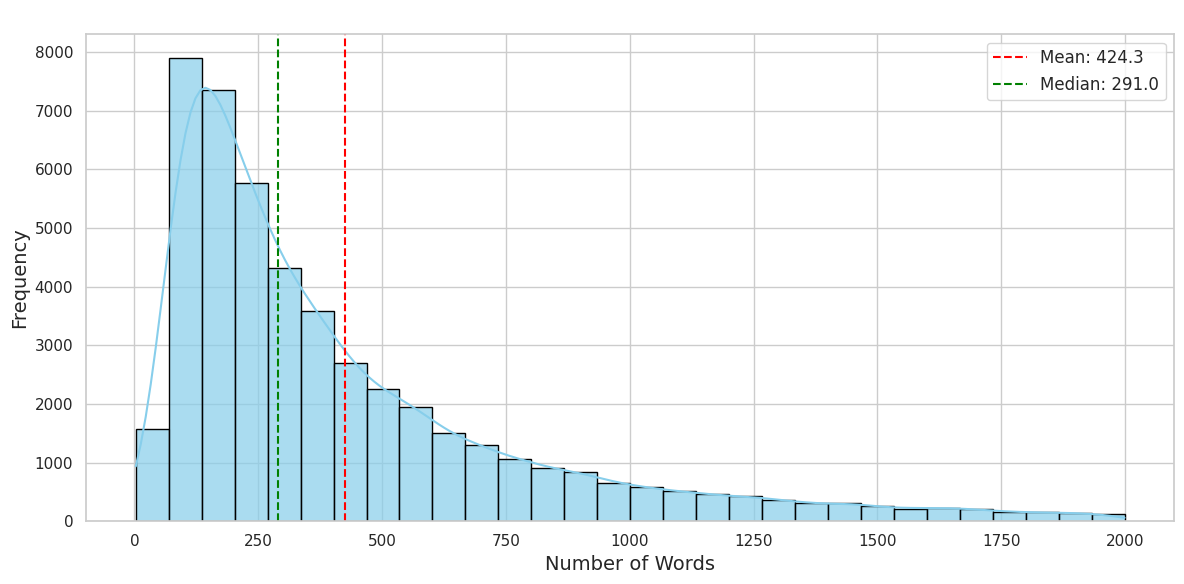

In [24]:
from pyspark.sql.functions import split, size, col
import seaborn as sns
import matplotlib.pyplot as plt

working_df = working_df.withColumn("thread_length", size(split(col("thread"), " ")))

# analzye and plot thread_length in the dense area
text_lengths = working_df.select("thread_length").rdd.flatMap(lambda x: x).collect()
filtered_lengths = [x for x in text_lengths if x < 2000]

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(filtered_lengths, kde=True, bins=30, color="skyblue", edgecolor="black", alpha=0.7)

# mean and median
mean_length = sum(filtered_lengths) / len(filtered_lengths)
median_length = sorted(filtered_lengths)[len(filtered_lengths) // 2]
plt.axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.1f}')
plt.axvline(median_length, color='green', linestyle='--', label=f'Median: {median_length:.1f}')


plt.title(" ", fontsize=16)
plt.xlabel("Number of Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

In [25]:
summary_stats = working_df.select("thread_length").rdd.map(lambda row: row[0]).stats()
min_length = summary_stats.min()
max_length = summary_stats.max()

# Compute 25th, 50th, and 75th percentiles using approxQuantile
percentiles = working_df.select("thread_length").approxQuantile("thread_length", [0.25, 0.5, 0.75], 0.01)

# Unpack the percentiles
percentile_25, median, percentile_75 = percentiles

In [26]:
print(f"Min Length: {min_length}")
print(f"Max Length: {max_length}")
print(f"25th Percentile: {percentile_25}")
print(f"50th Percentile (Median): {median}")
print(f"75th Percentile: {percentile_75}")

Min Length: 3.0
Max Length: 97156.0
25th Percentile: 162.0
50th Percentile (Median): 302.0
75th Percentile: 592.0


In [27]:
text_lengths = None
filtered_lengths = None
combined_answers_df = None

### Data preprocessing

The data preprocessing phase focused on preparing the text for analysis through a series of steps to ensure consistency and reduce noise. Key tasks included tokenization, lowercasing, and the removal of stop words using a combined approach that integrated SpaCy, NLTK, Scikit-learn, and a custom stop-word list tailored to the dataset. Further cleaning involved removing non-alphabetical characters and filtering out words with fewer than two characters, streamlining the textual data for more effective analysis.

In [28]:
from nltk import download
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import numpy as np
import nltk
import re
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [29]:
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm")

# combine stop words
spacy_stop_words = nlp.Defaults.stop_words
nltk_stop_words = set(stopwords.words('english'))
sklearn_stop_words = ENGLISH_STOP_WORDS
combined_stop_words = set(spacy_stop_words).union(nltk_stop_words, sklearn_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
def remove_urls(text):
    """Remove URLs from text."""
    return re.sub(r"http[s]?://\S+|www\.\S+", "", text)

def generate_word_tokens(stop_words):
    data = np.array(df.select('body').collect())
    word_tokens = []

    for body in data:
        for content in body:
            # Remove URLs
            content = remove_urls(content)

            # Tokenize words
            words = word_tokenize(content)

            # Process words: lowercase, remove punctuation/non-alphabetic, filter stop words
            processed_words = [
                word.lower() for word in words
                if word.lower() not in stop_words and
                word.isalpha()  # Keeps only alphabetic words
            ]

            word_tokens += processed_words
            words = None
    data = None
    return word_tokens

In [31]:
word_tokens = generate_word_tokens(combined_stop_words)

In [32]:
print(word_tokens[:50])

['dollhouse', 'drawing', 'close', 'need', 'new', 'tv', 'watch', 'figured', 'older', 'series', 'missed', 'current', 'series', 'gotten', 'check', 'list', 'suggestions', 'read', 'gim', 'ideas', 'currently', 'watching', 'dollhouse', 'lost', 'flashforward', 'v', 'true', 'blood', 'smallville', 'previously', 'watched', 'stargate', 'sure', 'missed', 'couple', 'seasons', 'buffy', 'angel', 'prolly', 'watch', 'rest', 'alias', 'seen', 'star', 'trek', 'tng', 'voyager', 'bit', 'enterprise', 'babylon']


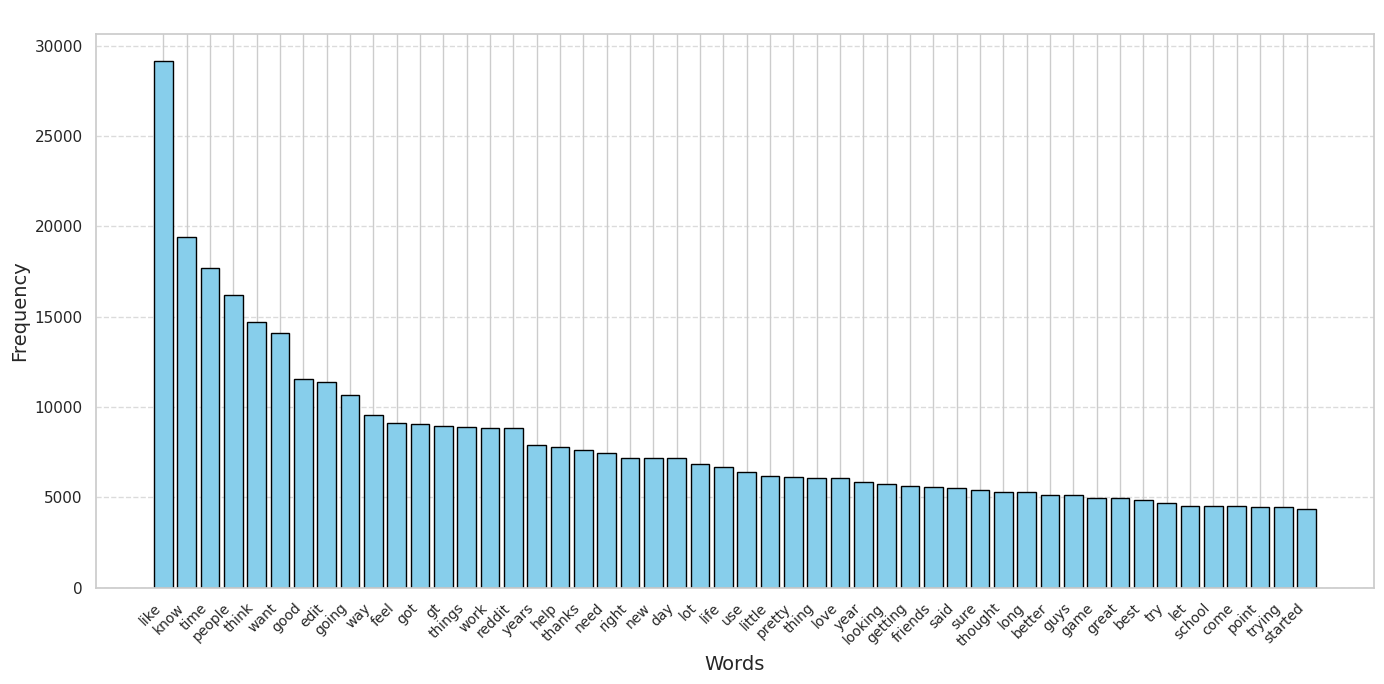

In [33]:
from collections import Counter

word_freq = Counter(word_tokens)

# Get the 50 most common words
most_common_words = word_freq.most_common(50)

# Separate words and their counts for plotting
words = [item[0] for item in most_common_words]
counts = [item[1] for item in most_common_words]

# Visualization
plt.figure(figsize=(14, 7))
plt.bar(words, counts, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(" ", fontsize=16, fontweight='bold')
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [34]:
most_common_count = sum(freq for _, freq in most_common_words) # most common words cnt
total_words = len(word_tokens) # total words cnt
most_common_proportion = (most_common_count / total_words * 100) if total_words > 0 else 0 # ratio of unique words

print(most_common_count)
print(total_words)
print(most_common_proportion)

405539
2719348
14.913096815854388


In [35]:
spacy_stop_words = None
nltk_stop_words = None
sklearn_stop_words  = None
counts = None
ENGLISH_STOP_WORDS = None
most_common_words = None
word_tokens = None

In [36]:
other_stop_words = ['the', 'to', 'and', 'a', 'of', 'that', 'in', 'on', 'with',
                    'but', 'or', 'if', 'from', 'http', 'www', 'imgur', 'jpg', 'gt', 'com', 'amp']
custom_stop_words = combined_stop_words.union(set(other_stop_words))

In [37]:
freq_dist = None

In [38]:
def generate_clean_corpus(stop_words):
    data = np.array(df.select('body').collect())
    word_tokens = []

    for body in data:
        for content in body:
            # Remove URLs
            content = remove_urls(content)

            # Tokenize words
            words = word_tokenize(content)

            # Process words: lowercase, remove punctuation/non-alphabetic, filter stop words,
            # length > 3
            processed_words = [
                word.lower() for word in words
                if word.lower() not in stop_words and
                   word.isalpha()  # Ensures the word is alphabetic
                  #  len(word) > 3  # Keeps words longer than 3 characters
            ]

            word_tokens += processed_words
            words = None
    data = None

    # Join the word tokens into a single string
    clean_corpus = ' '.join(word_tokens)

    return clean_corpus

In [39]:
corpus = generate_clean_corpus(custom_stop_words)

In [40]:
type(corpus)

str

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

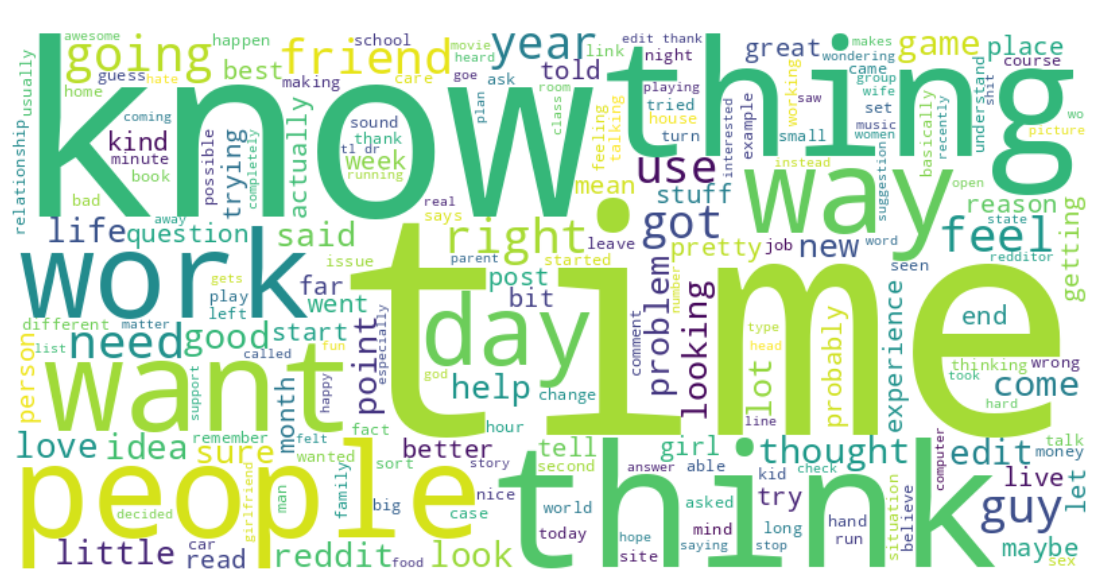

In [42]:
from wordcloud import WordCloud

word_cloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

# Display the word cloud
plt.figure(figsize=(14, 7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.title(" ")
plt.axis('off')
plt.show()

In [43]:
word_tokens = corpus.split()
corpus_length = len(word_tokens) # corpus length
unique_words = len(set(word_tokens)) # unique words
unique_word_percentage = (unique_words / corpus_length * 100) if corpus_length > 0 else 0 # ratio of unique words

print(corpus_length)
print(unique_words)
print(unique_word_percentage)

2708135
78984
2.916545888591226


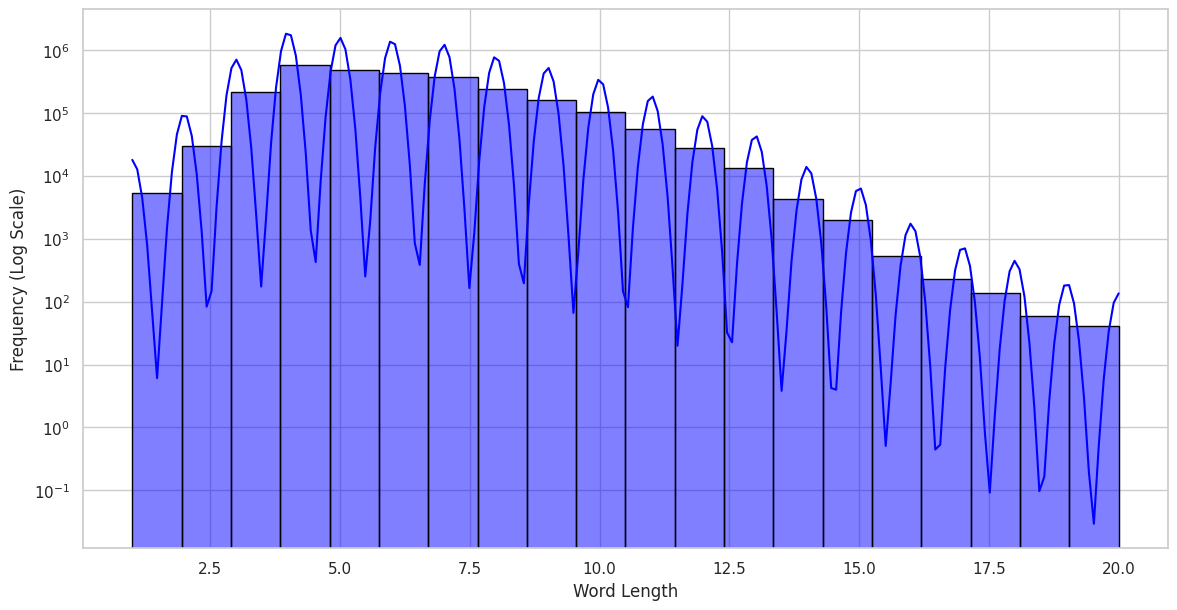

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

word_lengths = [len(word) for word in word_tokens]
# word length distribution
filtered_word_lengths = [length for length in word_lengths if 1 <= length <= 20]  # Filter out outliers

plt.figure(figsize=(14, 7))
sns.histplot(filtered_word_lengths, bins=20, kde=True, color="blue", edgecolor="black")

plt.xlabel("Word Length")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")
plt.show()

In [46]:
word_tokens = None
corpus = None
df = None
combined_stop_words = None
words = None
filtered_lengths = None
word_lengths = None
filtered_word_lengths = None
other_stop_words = None
word_cloud = None

### Topic modeling

This section outlines the process of converting textual data into a numerical format for topic modeling using a count vectorizer with specified parameters, followed by LDA to identify 20 topics. The approach ensures meaningful topic generation by weighting terms with IDF and limiting output to the five most relevant words per topic, allowing for effective categorization of threads based on their keywords.

In [47]:
from pyspark.sql import functions as f
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml import Pipeline

In [48]:
from pyspark.sql.functions import regexp_replace, col, concat_ws, trim

working_df = working_df.withColumn(
    'cleaned_threads', regexp_replace(col('thread'), '[^\w\s]', ' ')  # Remove non-alphanumeric characters
).withColumn(
    'cleaned_threads', regexp_replace(col('cleaned_threads'), '[0-9]', '')  # Remove digits
).withColumn(
    'cleaned_threads', regexp_replace(col('cleaned_threads'), '\\bhttp\\S+|www\\S+', '')  # Remove URLs
).withColumn(
    'cleaned_threads', regexp_replace(col('cleaned_threads'), '\\b\\w{1}\\b', '')  # Remove tokens with less than 2 characters
).withColumn(
    'cleaned_threads', regexp_replace(col('cleaned_threads'), '\\s+', ' ')  # Replace multiple spaces with single space
).withColumn(
    'cleaned_threads', trim(col('cleaned_threads'))  # Trim leading and trailing spaces
)

In [49]:
working_df.show(5)

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+
|             answers|                body|score|               title|    combined_answers|              thread|thread_length|     cleaned_threads|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+-------------+--------------------+
|[{body -> Have yo...|With Dollhouse dr...|   17|Sci-fi (-ish) tv ...|Have you seen [Th...|Sci-fi (-ish) tv ...|         1440|Sci fi ish tv ser...|
|[{body -> F*ck th...|How do you get th...|   20|For those who've ...|F*ck the glossary...|For those who've ...|          146|For those who ve ...|
|[{body -> Just be...|There's been a li...|   70|Want to effect ch...|Just be sure to c...|Want to effect ch...|          277|Want to effect ch...|
|[{body -> Hanging...|When I was a youn...|   16|I've lost my abil...|Hanging out with ...|I've lost my abil...|

In [50]:
from pyspark.sql.functions import monotonically_increasing_id

working_df = working_df.withColumn("index", monotonically_increasing_id())

In [51]:
working_df_ = working_df.select("index", "cleaned_threads", "score", "thread_length")

In [53]:
# tokenize the text using the cleaned-up version
tokenize = Tokenizer(inputCol = 'cleaned_threads',
                      outputCol = 'words')

# remove stop words
custom_stop_words = list(custom_stop_words)
remove_sw = StopWordsRemover(inputCol = 'words',
                             outputCol = 'filtered', stopWords=custom_stop_words)

# count vectorizer
cv = CountVectorizer(inputCol = 'filtered',
                     outputCol = 'counts' ,
                     vocabSize = 20000,
                     minDF = 5)

# compute the inverse document frequency
idf = IDF(inputCol = 'counts',
          outputCol = 'idf')

# create a pipeline and transform the articles data frame
pipeline = Pipeline() \
     .setStages([tokenize,
                 remove_sw,
                 cv,
                 idf])

pipeline_model = pipeline.fit(working_df_)

processed_df= pipeline_model\
  .transform(working_df_)

# processed_df\
#   .select('cleaned_threads', 'idf')\
#   .show(5, truncate = False)

In [54]:
lda = LDA(k=20, featuresCol='idf', maxIter=10)
lda_model = lda.fit(processed_df)

topics = lda_model.describeTopics(15)
# topics.show(truncate = False)

In [55]:
# Get the vocabulary from the CountVectorizer model
cv_model = pipeline_model.stages[2]
vocabulary = cv_model.vocabulary

In [56]:
def map_indices_to_words(indices):
    return [vocabulary[idx] for idx in indices[:5]]  # Limit to top 5 words

# Update the topic_words_dict to include only top 5 words per topic
topics = lda_model.describeTopics(15)
topic_words_dict = {
    row['topic']: map_indices_to_words(row['termIndices'])
    for row in topics.collect()
}

In [57]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def get_top_words(topic_distribution):
    most_probable_topic = max(enumerate(topic_distribution), key=lambda x: x[1])[0]
    return ' '.join(topic_words_dict.get(most_probable_topic, []))

get_top_words_udf = udf(get_top_words, StringType())

In [58]:
# Transform the processed_df to get topic distributions
document_topics = lda_model.transform(processed_df)

# Add the top words column to the original DataFrame
working_df_with_topics = working_df.join(
    document_topics.select('topicDistribution', 'index'),
    on='index'
).withColumn('top_words', get_top_words_udf(col('topicDistribution')))

In [61]:
vocabulary = None
working_df = None
filtered_word_lengths = None
custom_stop_words = None

In [62]:
working_df_with_topics_ordered = working_df_with_topics.orderBy(col("score").desc())

working_df_with_topics_ordered.select("title", "score", "top_words").show(truncate=False, n=10)

+--------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------+
|title                                                                                                                                 |score|top_words                               |
+--------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------+
|The health bill has PASSED!                                                                                                           |7249 |money job school people work            |
|Reddit, I've been promising this to you for months, and it's finally ready. I hope you like it.                                       |4984 |reddit comments flickr site post        |
|America, we need a third party that can galvanize our generation. One that does

### Toxic Bert

In this section, we applied the pre-trained Toxic-BERT model to calculate toxicity scores. Note that part of the code is commented out, as running the model took approximately 8 hours to process only half of the dataset due to computational constraints.

In [72]:
pip install torch

In [73]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [74]:
model_name = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set model to evaluation mode

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [75]:
def calculate_toxicity(batch_text):
    # Tokenize the batch of text
    inputs = tokenizer(batch_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Return toxicity probabilities (assume label 1 corresponds to "toxic")
    val =  [float(prob[1]) for prob in probs]
    return val[0]

In [76]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, ArrayType, StringType

# Define a UDF to calculate toxicity score
def get_toxicity_udf(text):
    try:
        score = calculate_toxicity([text])  # Process single row as a batch
        return score[0]
    except Exception as e:
        return float('nan')  # Handle errors gracefully

toxicity_udf = udf(get_toxicity_udf, FloatType())

In [77]:
# toxicity_scores = working_df_with_topics.select(
#      toxicity_udf(col("title").alias('toxicityscore'))
# )

In [78]:
# from pyspark.sql.functions import row_number,lit
# from pyspark.sql.window import Window

# w = Window().orderBy(lit('A'))
# working_df_with_topics = working_df_with_topics.withColumn('id', f.row_number().over(w))

### Toxic-BERT Data Analysis

In this section, we analyze the toxicity scores generated by the pre-trained Toxic-BERT model, exploring their distribution and relationships with other features such as engagement metrics and thread topics. This analysis aims to uncover patterns and insights into the prevalence and impact of toxic content within the dataset.

In [79]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [80]:
toxicity_scores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/toxicity_data_score.csv')

In [81]:
toxicity_df = spark.createDataFrame(toxicity_scores)

In [82]:
toxicity_scores = None
processed_df = None
working_df = None
working_df_ = None
working_df_with_topics_ordered = None

In [83]:
toxicity_df.show(5)

+--------------------+-----+------------------+
|               title|score|    toxicity_score|
+--------------------+-----+------------------+
|Sci-fi (-ish) tv ...|   17|0.0084290206432342|
|For those who've ...|   20|0.0688726380467414|
|Hi r/Islam! I hav...|   16|0.0194276608526706|
|At 11.19 a.m toda...|  228|0.0051054344512522|
|My Powerbook has ...|    3|0.0074058026075363|
+--------------------+-----+------------------+
only showing top 5 rows



In [84]:
toxicity_df.describe().show()

+-------+--------------------+------------------+--------------------+
|summary|               title|             score|      toxicity_score|
+-------+--------------------+------------------+--------------------+
|  count|               22903|             22903|               22903|
|   mean|                NULL| 34.00563244989739|0.020600010750658045|
| stddev|                NULL|137.26448049990358| 0.02345469879634159|
|    min|\n\nThe Matrix: 1...|                 3|   5.166953196749E-4|
|    max|“Me? I’m a lesbia...|              7249|  0.1013387814164161|
+-------+--------------------+------------------+--------------------+



In [85]:
quantiles = toxicity_df.approxQuantile("toxicity_score", [0.25, 0.5, 0.75], 0.01)

# Display the quantiles
print(f"25th percentile (Q1): {round(quantiles[0],4)}")
print(f"Median (Q2): {round(quantiles[1],2)}")
print(f"75th percentile (Q3): {round(quantiles[2],4)}")

25th percentile (Q1): 0.004
Median (Q2): 0.01
75th percentile (Q3): 0.0303


In [86]:
toxicity_df = toxicity_df.withColumn("title_length", F.length("title"))

In [87]:
toxicity_df.show(5)

+--------------------+-----+------------------+------------+
|               title|score|    toxicity_score|title_length|
+--------------------+-----+------------------+------------+
|Sci-fi (-ish) tv ...|   17|0.0084290206432342|          62|
|For those who've ...|   20|0.0688726380467414|          43|
|Hi r/Islam! I hav...|   16|0.0194276608526706|          32|
|At 11.19 a.m toda...|  228|0.0051054344512522|          54|
|My Powerbook has ...|    3|0.0074058026075363|          51|
+--------------------+-----+------------------+------------+
only showing top 5 rows



In [88]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Combine the columns into a single vector column
assembler = VectorAssembler(
    inputCols=["toxicity_score", "score", "title_length"],
    outputCol="features"
)
df_with_features = assembler.transform(toxicity_df)

# Compute the Pearson correlation matrix
correlation_matrix = Correlation.corr(df_with_features, "features").head()[0].toArray()

print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
[[ 1.         -0.0732165  -0.03165093]
 [-0.0732165   1.          0.06945673]
 [-0.03165093  0.06945673  1.        ]]


In [89]:
toxicity_df_ordered = toxicity_df.orderBy(col("toxicity_score").desc())

In [90]:
toxicity_df_ordered.show(truncate=False, n=10)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------------------+------------+
|title                                                                                                                                                                          |score|toxicity_score    |title_length|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------------------+------------+
|Thank you to everyone who participated in my study. I got an amazing response, and now have a sample size several times what I needed.                                         |16   |0.1013387814164161|134         |
|I just discovered Bach's Cello Suite #1 and it's so beautiful, it's inspiring me to start getting into classical music. Where should I 